In [37]:
from typing import Tuple
import itertools
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from monai.networks import nets, one_hot
from monai.metrics import compute_hausdorff_distance

import plotly.express as px
from plotly.colors import n_colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "simple_white"

import skimage as skm
from scipy import interpolate

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms

import torchio as tio

from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

In [38]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.data import ScdEvaluator, MnmEvaluator
from tagseg.data.dmd_dataset import DmdH5DataSet, DmdH5Evaluator
from tagseg.models.trainer import Trainer
from tagseg.models.segmenter import Net
from tagseg.metrics.dice import DiceMetric
from tagseg.pipelines.model_evaluation.nodes import tag_subjects
from tagseg.data.dmd_dataset import DmdDataSet

In [39]:
top_h_legend = dict(orientation='h', yanchor="bottom", y=1.1)

In [40]:
index = pd.read_csv('../data/07_model_output/index_gamma.csv')
index

,model,gamma
0,model_dmd_v8,0.001
1,model_dmd_v7,0.005
2,model_dmd_v6,0.050
3,model_dmd_v5,0.100
4,model_dmd_v4,0.500
5,model_dmd_v3,1.000
6,model_dmd_v1,0.000


In [41]:
dfs = [] 

for _, row in index.iterrows():

    for split in ['train', 'test']:

        ext = '_train' if split == 'train' else ''

        df = PickleDataSet(filepath=f'../data/07_model_output/{row.model}/dmd_results{ext}.pt').load()
        df = pd.DataFrame(list(df))

        df['gamma'] = row.gamma
        df['split'] = split

        dfs.append(df)

In [42]:
df = pd.concat(dfs)
len(df)

8750

In [43]:
results = df.pivot_table(index=['gamma'], values=['dice', 'hd95'], columns=['split'], aggfunc=['mean', 'median', 'std']) \
    .sort_index(level=[1, 2], ascending=[True, False], axis=1).reorder_levels([1, 2, 0], axis=1) \

results

dice                                                        hd95  \
split     train                          test                         train   
           mean    median       std      mean    median       std      mean   
gamma                                                                         
0.000  0.880232  0.882577  0.024945  0.768306  0.795023  0.094106  3.082279   
0.001  0.814916  0.815458  0.025202  0.771155  0.778124  0.045115  3.375328   
0.005  0.886200  0.888520  0.023161  0.769605  0.791245  0.102393  2.975902   
0.050  0.872231  0.874556  0.027364  0.800767  0.810722  0.064837  3.301001   
0.100  0.864842  0.866619  0.025859  0.797951  0.814230  0.082669  3.546927   
0.500  0.788529  0.791260  0.022610  0.735523  0.750099  0.049619  3.496116   
1.000  0.584712  0.589724  0.035122  0.556093  0.565265  0.041282  4.838324   

                                                          
split                          test                       
         median       std      mean    median        std  
gamma                                                     
0.000  2.857143  0.667756  7.700583  5.677400   8.967411  
0.001  3.194383  0.771494  5.358341  4.285714   5.945617  
0.005  2.857143  0.657751  7.627853  5.714286   9.414131  
0.050  3.194383  0.746071  5.615966  5.150788   1.989304  
0.100  3.194383  0.849212  6.423004  5.150788   5.313870  
0.500  3.194383  0.958205  6.449163  4.285714  10.824556  
1.000  4.132524  3.671633  5.714876  5.150788   1.975448

In [44]:
dices = np.array(results[('dice', 'test', 'mean')].sort_values(ascending=False))
hds = np.array(results[('hd95', 'test', 'mean')].sort_values(ascending=True))

In [45]:
results['dice_rank'] = results[('dice', 'test', 'mean')].apply(lambda d: np.where(np.isclose(dices, d))[0][0]) + 1
results['hd_rank'] = results[('hd95', 'test', 'mean')].apply(lambda hd: np.where(np.isclose(hds, hd))[0][0]) + 1 

results['rank'] = results['dice_rank'] + results['hd_rank']

In [46]:
results

dice                                                        hd95  \
split     train                          test                         train   
           mean    median       std      mean    median       std      mean   
gamma                                                                         
0.000  0.880232  0.882577  0.024945  0.768306  0.795023  0.094106  3.082279   
0.001  0.814916  0.815458  0.025202  0.771155  0.778124  0.045115  3.375328   
0.005  0.886200  0.888520  0.023161  0.769605  0.791245  0.102393  2.975902   
0.050  0.872231  0.874556  0.027364  0.800767  0.810722  0.064837  3.301001   
0.100  0.864842  0.866619  0.025859  0.797951  0.814230  0.082669  3.546927   
0.500  0.788529  0.791260  0.022610  0.735523  0.750099  0.049619  3.496116   
1.000  0.584712  0.589724  0.035122  0.556093  0.565265  0.041282  4.838324   

                                                         dice_rank hd_rank  \
split                          test                                          
         median       std      mean    median        std                     
gamma                                                                        
0.000  2.857143  0.667756  7.700583  5.677400   8.967411         5       7   
0.001  3.194383  0.771494  5.358341  4.285714   5.945617         3       1   
0.005  2.857143  0.657751  7.627853  5.714286   9.414131         4       6   
0.050  3.194383  0.746071  5.615966  5.150788   1.989304         1       2   
0.100  3.194383  0.849212  6.423004  5.150788   5.313870         2       4   
0.500  3.194383  0.958205  6.449163  4.285714  10.824556         6       5   
1.000  4.132524  3.671633  5.714876  5.150788   1.975448         7       3   

      rank  
split       
            
gamma       
0.000   12  
0.001    4  
0.005   10  
0.050    3  
0.100    6  
0.500   11  
1.000   10

In [47]:
print(results.to_latex(
    float_format="%.3f", bold_rows=True, column_format='llrrrrrrrr', multicolumn_format='c', multirow=True,
    caption='Something retarded'
))

\begin{table}
\centering
\caption{Something retarded}
\begin{tabular}{llrrrrrrrr}
\toprule
{} & \multicolumn{6}{c}{dice} & \multicolumn{6}{c}{hd95} & dice\_rank & hd\_rank & rank \\
\textbf{split} & \multicolumn{3}{c}{train} & \multicolumn{3}{c}{test} & \multicolumn{3}{c}{train} & \multicolumn{6}{c}{test} \\
{} &  mean & median &   std &  mean & median &   std &  mean & median &   std &  mean & median & \multicolumn{4}{c}{std} \\
\textbf{gamma} &       &        &       &       &        &       &       &        &       &       &        &        &           &         &      \\
\midrule
\textbf{0.000} & 0.880 &  0.883 & 0.025 & 0.768 &  0.795 & 0.094 & 3.082 &  2.857 & 0.668 & 7.701 &  5.677 &  8.967 &         5 &       7 &   12 \\
\textbf{0.001} & 0.815 &  0.815 & 0.025 & 0.771 &  0.778 & 0.045 & 3.375 &  3.194 & 0.771 & 5.358 &  4.286 &  5.946 &         3 &       1 &    4 \\
\textbf{0.005} & 0.886 &  0.889 & 0.023 & 0.770 &  0.791 & 0.102 & 2.976 &  2.857 & 0.658 & 7.628 &  5.714 &  9.4

/tmp/ipykernel_46354/318273618.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [48]:
res = results.reset_index().melt(id_vars=[('gamma',      '',     '')])
res.columns = ['gamma', 'metric', 'split', 'statistic', 'value']
res = res.pivot(index=['gamma', 'metric', 'split'], columns=['statistic']).reset_index()

In [49]:
res.columns = ['gamma', 'metric', 'split', 'bad', 'mean', 'median', 'std']
res = res.sort_values(by=['gamma', 'split'], ascending=[True, False])

In [50]:
fig = px.scatter(res, x='gamma', y='mean', facet_col='metric', color='split', error_y='std')

top_h_legend = dict(orientation='h', yanchor="bottom", y=1.1)
fig.update_layout(legend=top_h_legend)

fig.update_yaxes(matches=None)
fig.update_xaxes(type='log')

fig.show()

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [51]:
df[(df.split == 'test')][['gamma', 'dice']]

,gamma,dice
0,0.001,0.648157
1,0.001,0.683179
2,0.001,0.725001
3,0.001,0.781284
4,0.001,0.808099
...,...,...
245,0.000,0.813295
246,0.000,0.807323
247,0.000,0.782610
248,0.000,0.778035


In [52]:
df = df[(df.split == 'test')]

In [62]:
df[df.gamma.isin([0.05, 0.1])][['hd95', 'timeframe', 'disease', 'patient_id', 'slice', 'gamma']].groupby('gamma').median()

,hd95,timeframe
gamma,,
0.05,5.150788,12.0
0.10,5.150788,12.0


In [64]:
df[df.gamma == 0.05].sort_values('hd95').hd95

184     2.857143
183     2.857143
182     2.857143
217     2.857143
220     2.857143
         ...    
62     10.935241
46     10.964106
38     11.373682
25     11.428572
61     12.777532
Name: hd95, Length: 250, dtype: float64

In [65]:
df[df.gamma == 0.1].sort_values('hd95').hd95

101     2.857143
224     2.857143
223     2.857143
102     2.857143
103     3.194383
         ...    
59     28.758866
77     35.015296
62     40.312872
60     43.384837
61     46.676111
Name: hd95, Length: 250, dtype: float64

In [90]:
subject_1.hd95, subject_2.hd95

(2.8571429252624, 2.8571429252624)

(140.0, 70.0)

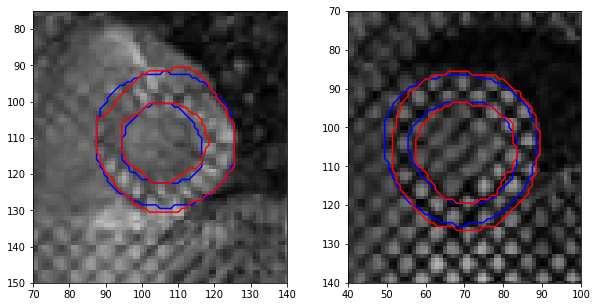

In [88]:
from skimage import measure

subject_1 = df[df.gamma == 0.05].iloc[184]
subject_2 = df[df.gamma == 0.1].iloc[101]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
raw_shape = subject_1.raw_mask.data[0, 0].shape
postprocess = transforms.Resize(raw_shape, interpolation=transforms.InterpolationMode.NEAREST)
plt.imshow(postprocess(subject_1.image.data)[0, 0], cmap='gray')
mask = subject_1.raw_mask.data[0, 0].numpy()
pred = subject_1.pred.data[0, 0].numpy()
for i, (contour_m, contour_p) in enumerate(zip(measure.find_contours(mask), measure.find_contours(pred))):
    plt.plot(*contour_m[:, ::-1].T, c='b')
    plt.plot(*contour_p[:, ::-1].T, c='r')
plt.xlim(70, 140)
plt.ylim(150, 75)

plt.subplot(1, 2, 2)
raw_shape = subject_2.raw_mask.data[0, 0].shape
postprocess = transforms.Resize(raw_shape, interpolation=transforms.InterpolationMode.NEAREST)
plt.imshow(postprocess(subject_2.image.data)[0, 0], cmap='gray')
mask = subject_2.raw_mask.data[0, 0].numpy()
pred = subject_2.pred.data[0, 0].numpy()
for i, (contour_m, contour_p) in enumerate(zip(measure.find_contours(mask), measure.find_contours(pred))):
    plt.plot(*contour_m[:, ::-1].T, c='b')
    plt.plot(*contour_p[:, ::-1].T, c='r')
plt.xlim(40, 100)
plt.ylim(140, 70)

In [53]:
metrics = ['dice', 'hd95']
gammas = sorted(df.gamma.unique())

colors = n_colors('rgb(25, 114, 120)', 'rgb(40, 61, 59)', len(gammas), colortype='rgb')

fig = make_subplots(
    rows=1, cols=len(metrics), 
    shared_yaxes=True, shared_xaxes=False, 
    horizontal_spacing=0.02, vertical_spacing=0.0
)

for m, metric in enumerate(metrics):

    data = np.array(list(map(
        lambda g: np.array(df[(df.gamma == g) & (df.split == 'test')][metric]), gammas
    )))

    for g, (data_line, color) in enumerate(zip(data, colors)):
        fig.add_trace(go.Violin(name=gammas[g], x=data_line, line_color=color), row=1, col=m + 1)

    fig.add_vline(
        x=data.mean(),
        annotation_text=f"    {data.mean():.3f}", annotation_position="top right", 
        annotation_font_color='rgb(40, 61, 59)',
        line_width=3, line_dash="dot", line_color='rgb(40, 61, 59)', row=1, col=m + 1)

fig.update_xaxes(
    title_text=r'DSC (↑)',
    range=[0.1, 1.1], tickvals=np.arange(0.2, 1.1, 0.1,), row=1, col=1)
fig.update_xaxes(
    title_text=r'HD-95 [mm] (↓)',
    range=[0., 15.], tickvals=np.arange(0., 15., 2.5,), row=1, col=2)

fig.update_yaxes(
    title_text='Weight of Shape Distance Loss (Gamma)', row=1, col=1)

fig.update_layout(height=800 / 1.62, width=800, showlegend=False)
fig.update_traces(
    meanline_visible=False, 
    box_visible=True, orientation='h', side='positive', width=3, points=False)
fig.show()

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [54]:
fig.write_image("../../figures/sdl-perf-violin.pdf")

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning:

NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning:

ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.



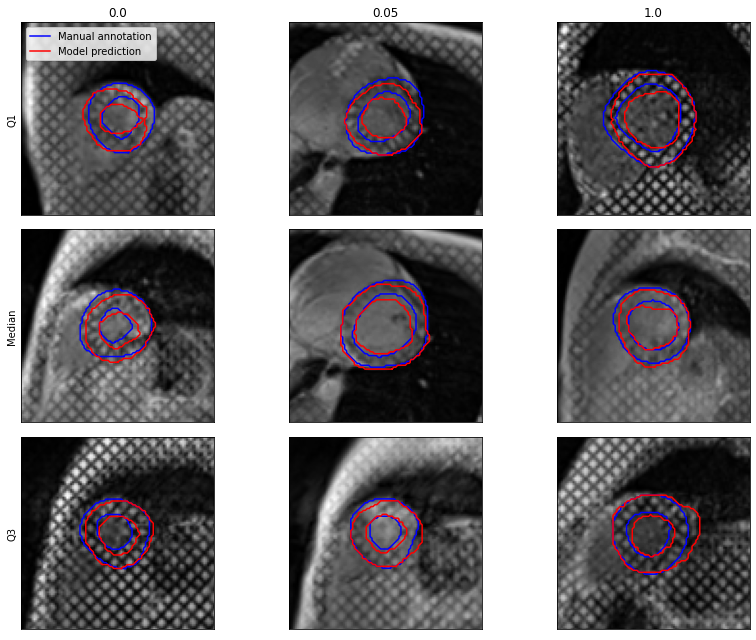

In [27]:
gammas = [0.0, 0.05, 1.0]

fig, ax = plt.subplots(3, len(gammas), figsize=(12, 9))

padding = 50

for m, gamma in enumerate(gammas):

    subs = df[(df.gamma == gamma)].copy()

    for i, (title, quantile) in enumerate(zip(['Q1', 'Median', 'Q3'], subs.dice.quantile([.25, .5, .75]))):

        subs['diff'] = (subs.dice - quantile).abs()

        subject = subs.sort_values('diff', ascending=True).iloc[0]

        post_process = transforms.Resize(subject.raw_shape)

        image = post_process(subject.image.data)[0, 0].numpy()
        mask = subject['raw_mask'].data[0, 0].numpy()
        pred = subject.pred.data[0, 0].numpy()

        center = [list(map(lambda a: a.mean(), np.where(mask == 1))), list(map(lambda a: a.mean(), np.where(pred == 1)))]

        ax[i, m].imshow(image, cmap='gray')

        # Label only once
        for j, contour in enumerate(skm.measure.find_contours(mask, level=.5)):
            ax[i, m].plot(*contour[:, ::-1].T, c='b', label='Manual annotation' if j == 0 else None)
        for j, contour in enumerate(skm.measure.find_contours(pred, level=.5)):
            ax[i, m].plot(*contour[:, ::-1].T, c='r', label='Model prediction' if j == 0 else None)

        ax[i, m].get_xaxis().set_ticks([])
        ax[i, m].get_yaxis().set_ticks([])

        center_y, center_x = np.array(center).mean(axis=0)
        ax[i, m].set_xlim(center_x - padding, center_x + padding)
        ax[i, m].set_ylim(center_y + padding, center_y - padding)
        
        ax[i, 0].set_ylabel(title)

    ax[0, m].set_title(gamma)

ax[0, 0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../../figures/qualitative-ShapeLoss.pdf', bbox_inches='tight')
plt.show()